# Probablistic Graphical Models of Behavior

In the following code we make models of the behavior for the rat random dots kinetogram (RDK) task with priors. In this task the rat nosepokes in a center nosepoke in order to start a trial. The stimulus consists of hundreds of moving dots. The coherence describes the percentage of dots moving in one of the two reward directions (leftward or rightward). The rest of the dots move in a random direction. Coherences are thus described as a real number $\in [-1,1]$, with -1 corresponding to 100% coherence leftward.

In blocks of trials, the prior probability with which leftward vs. rightward trials are presented changes. For instance, for the first 100 trials the prior might dictate that 25% of trials were leftward, whereas for the next 100 trials, 75% of the trials would be leftward. We wish to model the behavioral effects of how the rat combines the noisy sensory stimulus with the information from the prior.

First we start off with some code to load libraries and data.

In [119]:
import pymc3 as pm
import numpy as np
import scipy.io as sio
import glob
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import cycle
import daftHM
import matplotlib
from matplotlib import rc
rc("font", family="serif", size=22)
rc("text", usetex=False)
matplotlib.rcParams.update({'font.size': 40})
import theano
from IPython.core.pylabtools import figsize

%matplotlib inline

color_cycle = cycle(['g', 'b', 'c', 'm', 'y', 'k'])

In [2]:
def load_RDK_data_from_mat_to_pandas(filename):
    mat = sio.loadmat(filename)
    mat = mat['temp_obj'][0]
    field_names = mat.dtype.names
    data = mat[0]
    data_dict = dict(zip(field_names,data))
    for key in data_dict:
        data_dict[key] = data_dict[key].squeeze()

    return data_dict

## A simple signal detection model

In all the models to come we wish to explain the string of leftward or rightward decisions that the rat makes. We will call the decision vector $N^R$ for 'nosepoke rightward', with a 1 indicating the rat nosepoked rightward, and a 0 indicating that the rat nosepoked leftward. For each trial, we additionally have the coherence value, $c$. As experimentalists, we have perfect knowledge of the prior, however the rat must infer this just from the sequence of coherences, so we will not be using this as an input into the model.

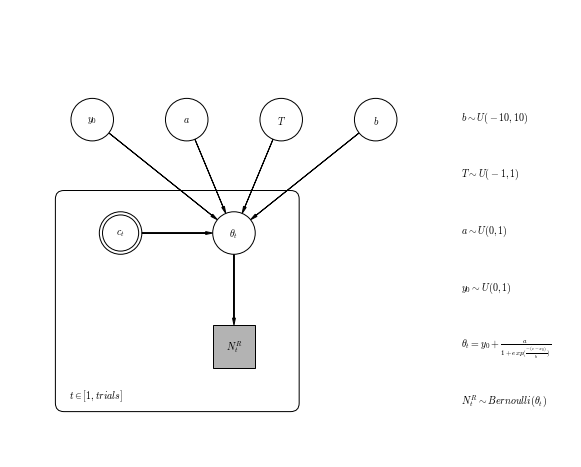

In [109]:
pgm = daftHM.PGM(shape=[5, 4], origin=[0, 0], observed_style='shaded', node_unit=1.5,grid_unit = 4.)

# Nodes
pgm.add_node(daftHM.Node(name="psych", content=r"$\theta_t$", x=2, y=2))
pgm.add_node(daftHM.Node(name="response", content=r"$N^R_t$", x=2, y=1, observed=True, continuous=False))
pgm.add_node(daftHM.Node(name="coherence", content=r"$c_t$", x=1, y=2, fixed = True))

LL, NN = 2.5, 3
DD = LL/NN
pgm.add_node(daftHM.Node(name="y0", content=r"$y_0$", x=2-LL/2, y=3))
pgm.add_node(daftHM.Node(name="a", content=r"$a$", x=2-LL/2+DD, y=3))
pgm.add_node(daftHM.Node(name="T", content=r"$T$", x=2-LL/2+2*DD, y=3))
pgm.add_node(daftHM.Node(name="b", content=r"$b$", x=2-LL/2+3*DD, y=3))


#Edges
pgm.add_edge("psych", "response")
pgm.add_edge("coherence", "psych")
pgm.add_edge("y0", "psych")
pgm.add_edge("a", "psych")
pgm.add_edge("T", "psych")
pgm.add_edge("b", "psych")


#Plates
pgm.add_plate(daftHM.Plate([.5, .5, 2, 1.8], label=r"$t \in [1,trials]$"))

#Equations
pgm.add_equation(daftHM.Equation(r"$b \sim U(-10,10)$",4,3))
pgm.add_equation(daftHM.Equation(r"$T \sim U(-1,1)$",4,2.5))
pgm.add_equation(daftHM.Equation(r"$a \sim U(0,1)$",4,2))
pgm.add_equation(daftHM.Equation(r"$y_0 \sim U(0,1)$",4,1.5))
pgm.add_equation(daftHM.Equation(r"$\theta_t = y_0 + \frac{a}{1+exp(\frac{-(c-x_0)}{b})}$",4, 1.))
pgm.add_equation(daftHM.Equation(r"$N^R_t \sim Bernoulli(\theta_t)$",4.0, 0.5))

#Plot
pgm.render()

In [199]:
rat_name = 'miley0'
data = load_RDK_data_from_mat_to_pandas('/home/adam/Documents/DATA/RDK/Behavior_1/Adam20170516/'+rat_name+'_session1.spd')
data = pd.DataFrame.from_dict(data)
data.index.name = 'trial'

c = np.ravel(data.coherence)
response_data = np.ravel(data.response_right)

with pm.Model() as model:
    y0 = pm.Uniform("y0",0,1)
    a = pm.Uniform("a",0,1-y0)
    T = pm.Uniform("T",-1,1)
    b = pm.Uniform("b",-10,10)
      
    theta_ = y0 + a * theano.tensor.nnet.nnet.sigmoid(-(c-T)/b)    
    theta = pm.Deterministic("theta",theta_)
        
    NR = pm.Bernoulli("NR",theta,observed=response_data)   

with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 15000/15000 [00:22<00:00, 665.63it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1681.19it/s]


AssertionError: 

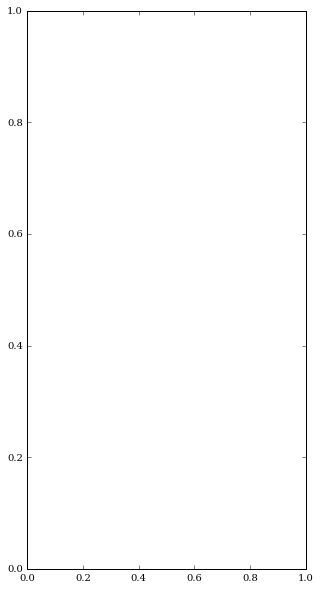

In [183]:
ppc = pm.sample_ppc(trace, model=model, samples=1000)

plt.errorbar(x=np.linspace(-1,1), y=np.asarray(ppc['NR']).mean(axis=0), yerr=np.asarray(ppc['NR']).std(axis=0), linestyle='', marker='o')
#plt.plot(predictors_oos, outcomes_oos, 'o')
#plt.ylim(-.05, 1.05)
plt.xlabel('predictor')
plt.ylabel('outcome')

In [185]:
np.asarray(ppc['NR']).mean(axis=0).shape

(664,)

/home/adam/anaconda2/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


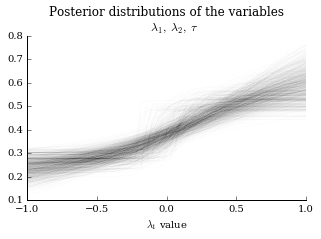

In [186]:
T_traces = trace['T']
a_traces = trace['a']
y0_traces = trace['y0']
b_traces = trace['b']

figsize(5, 10)
coherences = np.linspace(-1,1)
ax = plt.subplot(311)

psych = lambda y0,a,T,b,c: y0 + a /(1+np.exp((c-T)/b))

for i in range(8000,9999):
    plt.plot(coherences,psych(y0_traces[i],a_traces[i],T_traces[i],b_traces[i],coherences),alpha=0.005,c='k')

plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([-1,1 ])
plt.xlabel("$\lambda_1$ value")


simpleaxis(ax)

In [154]:
psych(y0_traces[1],a_traces[1],T_traces[1],b_traces[1],coherences)
y0_traces

array([ 0.2941811 ,  0.2941811 ,  0.2941811 , ...,  0.01135216,
        0.00518427,  0.00346021])

## Trial by trial autocorrelated estimate of prior

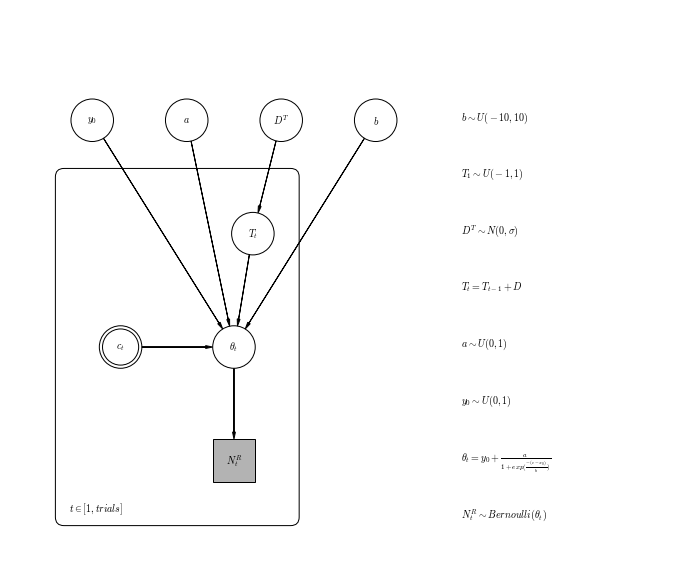

In [108]:
pgm = daftHM.PGM(shape=[6, 5], origin=[0, 0], observed_style='shaded', node_unit=1.5,grid_unit = 4.)

# Nodes
pgm.add_node(daftHM.Node(name="psych", content=r"$\theta_t$", x=2, y=2))
pgm.add_node(daftHM.Node(name="response", content=r"$N^R_t$", x=2, y=1, observed=True, continuous=False))
pgm.add_node(daftHM.Node(name="coherence", content=r"$c_t$", x=1, y=2, fixed = True))

LL, NN = 2.5, 3
DD = LL/NN
pgm.add_node(daftHM.Node(name="y0", content=r"$y_0$", x=2-LL/2, y=4))
pgm.add_node(daftHM.Node(name="a", content=r"$a$", x=2-LL/2+DD, y=4))
pgm.add_node(daftHM.Node(name="T", content=r"$T_t$", x=2-LL/2+2*DD-0.25, y=3))
pgm.add_node(daftHM.Node(name="DT", content=r"$D^T$", x=2-LL/2+2*DD, y=4))
pgm.add_node(daftHM.Node(name="b", content=r"$b$", x=2-LL/2+3*DD, y=4))


#Edges
pgm.add_edge("psych", "response")
pgm.add_edge("coherence", "psych")
pgm.add_edge("y0", "psych")
pgm.add_edge("a", "psych")
pgm.add_edge("T", "psych")
pgm.add_edge("b", "psych")
pgm.add_edge("DT", "T")


#Plates
pgm.add_plate(daftHM.Plate([.5, .5, 2, 3], label=r"$t \in [1,trials]$"))

#Equations
pgm.add_equation(daftHM.Equation(r"$b \sim U(-10,10)$",4,4))

pgm.add_equation(daftHM.Equation(r"$T_1 \sim U(-1,1)$",4,3.5))
pgm.add_equation(daftHM.Equation(r"$D^T \sim N(0,\sigma)$",4,3))
pgm.add_equation(daftHM.Equation(r"$T_t = T_{t-1} + D$",4,2.5))
pgm.add_equation(daftHM.Equation(r"$a \sim U(0,1)$",4,2))
pgm.add_equation(daftHM.Equation(r"$y_0 \sim U(0,1)$",4,1.5))
pgm.add_equation(daftHM.Equation(r"$\theta_t = y_0 + \frac{a}{1+exp(\frac{-(c-x_0)}{b})}$",4, 1.))
pgm.add_equation(daftHM.Equation(r"$N^R_t \sim Bernoulli(\theta_t)$",4.0, 0.5))

#Plot
pgm.render()

In [205]:
rat_name = 'miley0'
data = load_RDK_data_from_mat_to_pandas('/home/adam/Documents/DATA/RDK/Behavior_1/Adam20170516/'+rat_name+'_session1.spd')
data = pd.DataFrame.from_dict(data)
data.index.name = 'trial'

c = np.ravel(data.coherence)
response_data = np.ravel(data.response_right)

num_trials = len(data)

with pm.Model() as model:
    y0 = pm.Uniform("y0",0,1)
    a = pm.Uniform("a",0,1-y0)
    b = pm.Uniform("b",-10,10)
    
    D = pm.Normal("D",0,0.5,shape=num_trials)
    
    thresh_vec = []
    theta_vec = []
    
    thresh_vec.append(pm.Uniform("T{0}".format(0),-1,1))
    theta_vec.append(y0 + a * theano.tensor.nnet.nnet.sigmoid((c[0]-thresh_vec[0])/b))
    
    for trial in np.arange(1,num_trials):
        thresh_vec.append(pm.Deterministic("T{0}".format(trial),thresh_vec[trial-1]+D[trial]))
        theta_vec.append(y0 + a * theano.tensor.nnet.nnet.sigmoid((c[trial]-thresh_vec[trial])/b))
    
    
    NR = pm.Bernoulli("NR",theta_vec,observed=response_data)
   

with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

KeyboardInterrupt: 

## A model with switchpoints between psychophysical curves

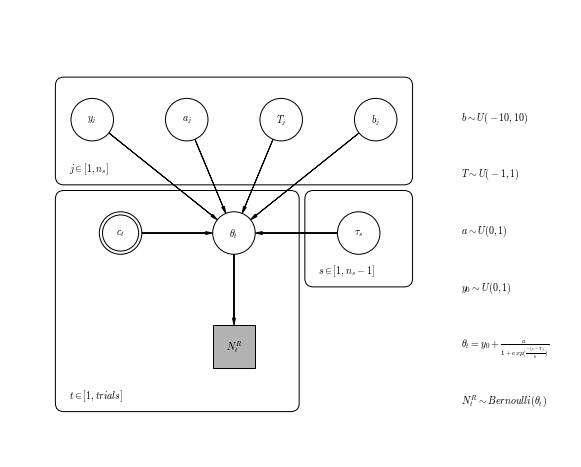

In [107]:
pgm = daftHM.PGM(shape=[5, 4], origin=[0, 0], observed_style='shaded', node_unit=1.5,grid_unit = 4.)

# Nodes
pgm.add_node(daftHM.Node(name="psych", content=r"$\theta_t$", x=2, y=2))
pgm.add_node(daftHM.Node(name="response", content=r"$N^R_t$", x=2, y=1, observed=True, continuous=False))
pgm.add_node(daftHM.Node(name="coherence", content=r"$c_t$", x=1, y=2, fixed = True))

LL, NN, offset = 2.5, 3, 0
DD = LL/NN
pgm.add_node(daftHM.Node(name="y0", content=r"$y_j$", x=2-LL/2+offset, y=3))
pgm.add_node(daftHM.Node(name="a", content=r"$a_j$", x=2-LL/2+DD+offset, y=3))
pgm.add_node(daftHM.Node(name="T", content=r"$T_j$", x=2-LL/2+2*DD+offset, y=3))
pgm.add_node(daftHM.Node(name="b", content=r"$b_j$", x=2-LL/2+3*DD+offset, y=3))

pgm.add_node(daftHM.Node(name="tau", content=r"$\tau_s$", x=3.1, y=2))


#Edges
pgm.add_edge("psych", "response")
pgm.add_edge("coherence", "psych")
pgm.add_edge("y0", "psych")
pgm.add_edge("a", "psych")
pgm.add_edge("T", "psych")
pgm.add_edge("b", "psych")
pgm.add_edge("tau", "psych")


#Plates
pgm.add_plate(daftHM.Plate([.5, .5, 2, 1.8], label=r"$t \in [1,trials]$"))
pgm.add_plate(daftHM.Plate([0.5, 2.5, 3, 0.8], label=r"$j \in [1,n_{s}]$"))
pgm.add_plate(daftHM.Plate([2.7, 1.6, 0.8, 0.7], label=r"$s \in [1,n_{s}-1]$"))

#Equations
pgm.add_equation(daftHM.Equation(r"$b \sim U(-10,10)$",4,3))
pgm.add_equation(daftHM.Equation(r"$T \sim U(-1,1)$",4,2.5))
pgm.add_equation(daftHM.Equation(r"$a \sim U(0,1)$",4,2))
pgm.add_equation(daftHM.Equation(r"$y_0 \sim U(0,1)$",4,1.5))
pgm.add_equation(daftHM.Equation(r"$\theta_t = y_0 + \frac{a}{1+exp(\frac{-(c-T)}{b})}$",4, 1.))
pgm.add_equation(daftHM.Equation(r"$N^R_t \sim Bernoulli(\theta_t)$",4.0, 0.5))

#Plot
pgm.render()

In [165]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [194]:
thresh_vec

[T0,
 T1,
 T2,
 T3,
 T4,
 T5,
 T6,
 T7,
 T8,
 T9,
 T10,
 T11,
 T12,
 T13,
 T14,
 T15,
 T16,
 T17,
 T18,
 T19,
 T20,
 T21,
 T22,
 T23,
 T24,
 T25,
 T26,
 T27,
 T28,
 T29,
 T30,
 T31,
 T32,
 T33,
 T34,
 T35,
 T36,
 T37,
 T38,
 T39,
 T40,
 T41,
 T42,
 T43,
 T44,
 T45,
 T46,
 T47,
 T48,
 T49,
 T50,
 T51,
 T52,
 T53,
 T54,
 T55,
 T56,
 T57,
 T58,
 T59,
 T60,
 T61,
 T62,
 T63,
 T64,
 T65,
 T66,
 T67,
 T68,
 T69,
 T70,
 T71,
 T72,
 T73,
 T74,
 T75,
 T76,
 T77,
 T78,
 T79,
 T80,
 T81,
 T82,
 T83,
 T84,
 T85,
 T86,
 T87,
 T88,
 T89,
 T90,
 T91,
 T92,
 T93,
 T94,
 T95,
 T96,
 T97,
 T98,
 T99,
 T100,
 T101,
 T102,
 T103,
 T104,
 T105,
 T106,
 T107,
 T108,
 T109,
 T110,
 T111,
 T112,
 T113,
 T114,
 T115,
 T116,
 T117,
 T118,
 T119,
 T120,
 T121,
 T122,
 T123,
 T124,
 T125,
 T126,
 T127,
 T128,
 T129,
 T130,
 T131,
 T132,
 T133,
 T134,
 T135,
 T136,
 T137,
 T138,
 T139,
 T140,
 T141,
 T142,
 T143,
 T144,
 T145,
 T146,
 T147,
 T148,
 T149,
 T150,
 T151,
 T152,
 T153,
 T154,
 T155,
 T156,
 T157,
 T15